Epoch 1/10, Loss: 0.3405708968639374
Epoch 2/10, Loss: 0.2802087068557739
Epoch 3/10, Loss: 0.2528654932975769
Epoch 4/10, Loss: 0.23615196347236633
Epoch 5/10, Loss: 0.22452878952026367
Epoch 6/10, Loss: 0.21601669490337372
Epoch 7/10, Loss: 0.20961670577526093
Epoch 8/10, Loss: 0.2044609934091568
Epoch 9/10, Loss: 0.20013949275016785
Epoch 10/10, Loss: 0.1964842975139618
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


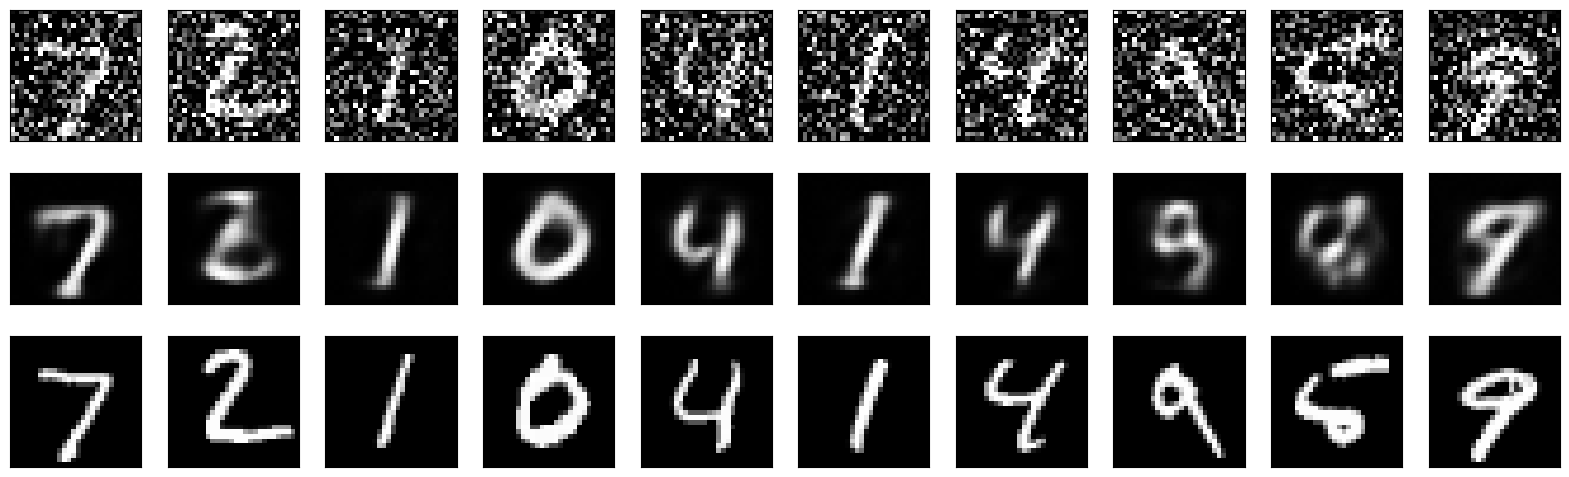

In [4]:
################################Sparse Auto-encoder################################

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the data to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images from 28x28 to 784-dimensional vectors
x_train = x_train.reshape((len(x_train), 28 * 28))
x_test = x_test.reshape((len(x_test), 28 * 28))

# Add random noise to the images
def add_noise(x, noise_factor=0.5):
    noisy = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
    return np.clip(noisy, 0., 1.)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

# Define the sparse autoencoder model
input_dim = 28 * 28
encoding_dim = 32  # Dimension of the encoding
sparsity_level = 0.1  # Desired sparsity level

# Input layer
input_img = layers.Input(shape=(input_dim,))

# Encoding layer with L1 regularization to promote sparsity
encoded = layers.Dense(encoding_dim, activation='relu',
                       activity_regularizer=regularizers.l1(1e-5))(input_img)

# Decoding layer
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

# Define the autoencoder model
autoencoder = models.Model(input_img, decoded)

# Define the encoder model (for visualization or further usage)
encoder = models.Model(input_img, encoded)

# Define the decoder model
encoded_input = layers.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = models.Model(encoded_input, decoder_layer(encoded_input))

'''
# Define custom loss function with sparsity penalty
def compute_loss(x_true, x_pred, avg_activation):
    # Reconstruction loss
    reconstruction_loss = tf.keras.losses.binary_crossentropy(x_true, x_pred)

    # Sparsity penalty (match the shape of avg_activation)
    sparsity_target = tf.fill(avg_activation.shape, sparsity_level)
    sparsity_penalty = sparsity_level * tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(sparsity_target, avg_activation)
    )

    return reconstruction_loss + sparsity_penalty

'''
# Compile the model (without loss for custom loop)
autoencoder.compile(loss='mse',optimizer='adam')

# Custom training loop
def train_autoencoder(x_train_noisy, x_train, epochs=10, batch_size=256):
    num_batches = len(x_train_noisy) // batch_size
    for epoch in range(epochs):
        for i in range(num_batches):
            batch_x_noisy = x_train_noisy[i * batch_size:(i + 1) * batch_size]
            batch_x_clean = x_train[i * batch_size:(i + 1) * batch_size]

            with tf.GradientTape() as tape:
                # Forward pass
                decoded_imgs = autoencoder(batch_x_noisy, training=True)
                encoded_imgs = encoder(batch_x_noisy, training=True)

                # Compute the average activation of the hidden layer
                avg_activation = tf.reduce_mean(encoded_imgs, axis=0)

                # Compute loss
                loss = compute_loss(batch_x_clean, decoded_imgs, avg_activation)

            # Compute gradients
            grads = tape.gradient(loss, autoencoder.trainable_variables)
            autoencoder.optimizer.apply_gradients(zip(grads, autoencoder.trainable_variables))

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy().mean()}')

# Train the model
train_autoencoder(x_train_noisy, x_train, epochs=10)

# Encode and decode some digits
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

# Display some results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display noisy input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised output
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display clean original
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()